In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load, Topos
from scipy.optimize import newton
from matplotlib import pyplot as plt
planets = load('de423.bsp')

In [2]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023, e_c = 0.175, e_sigma = 0.06, i_sigma = 12,\
                 amp_c = 75, amp_max = 155, amp_min = 0):
        self.size = size
        self.mjd = mjd
        self.lambda_N = 0
        self.a = self.gen_a()
        self.e = self.gen_e(e_c, e_sigma)
        self.i = self.gen_i(i_sigma)
        self.amp = self.gen_amp(amp_c, amp_max, amp_min)
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg(self.phi, self.M, self.node, self.lambda_N)
        self.H = self.gen_H()
        cut = (self.e > 0) * (~np.isnan(self.i))
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        X, Y, Z, r = zip(*map(self.kep_to_xyz, self.a, self.e, self.i,\
                                                  self.arg, self.node, self.M)) # r**2 = X**2 + Y**2 + Z**2
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Z = np.array(Z)
        self.r = np.array(r)
        self.xyz_to_equa(self.X, self.Y, self.Z)
        self.H_to_mag()
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self, e_c, e_sigma):
        return np.random.normal(loc=e_c, scale=e_sigma, size = self.size)
        
    def gen_i(self, i_sigma):
        return np.arcsin(np.random.rayleigh(scale = i_sigma * np.pi/180., size = self.size))
        
    def gen_amp(self, amp_c, amp_max, amp_min):
        return np.random.triangular(amp_min, amp_c, amp_max, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self, phi, M, node, lambda_N):
        return (0.5*phi - 1.5*M - node + lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the radius
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z, r
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        self.earth_dis = (x_earth**2 + y_earth**2 + z_earth**2)**0.5
        X = X0 - x_earth
        Y = Y0 * np.cos(epsilon) + Z0 * np.sin(epsilon)  - y_earth
        Z = Y0 * np.sin(epsilon) - Z0 * np.cos(epsilon) - z_earth
        self.delta = (X**2 + Y**2+ Z**2)**0.5
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)
        
    def H_to_mag(self):
        phase = np.arccos((self.r**2 + self.delta**2 - self.earth_dis**2) / (2 * self.r * self.delta))
        phase_integral = 2/3. * ((1-phase/np.pi)*np.cos(phase) + 1/np.pi*np.sin(phase))
        self.mag = self.H + 2.5 * np.log10((self.r**2 * self.delta**2) / phase_integral)
        
        

In [19]:
p = plutino(size = 2000, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0, i_sigma=12)

(array([ 90.,  94., 108., 105., 102.,  99., 102., 102.,  83.,  98., 101.,
         92.,  97., 103.,  95., 113., 103.,  93.,  92., 128.]),
 array([39.25019432, 39.27018243, 39.29017054, 39.31015864, 39.33014675,
        39.35013486, 39.37012297, 39.39011107, 39.41009918, 39.43008729,
        39.4500754 , 39.47006351, 39.49005161, 39.51003972, 39.53002783,
        39.55001594, 39.57000405, 39.58999215, 39.60998026, 39.62996837,
        39.64995648]),
 <a list of 20 Patch objects>)

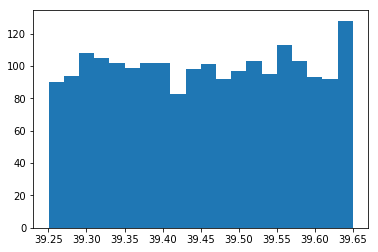

In [20]:
plt.hist(p.a, bins = 20)

(array([  2.,   2.,  15.,  30.,  53.,  85., 126., 186., 233., 238., 274.,
        226., 195., 143.,  77.,  54.,  40.,  14.,   3.,   4.]),
 array([0.26679029, 0.27010583, 0.27342137, 0.27673691, 0.28005245,
        0.28336799, 0.28668353, 0.28999907, 0.29331461, 0.29663015,
        0.29994569, 0.30326123, 0.30657677, 0.30989231, 0.31320785,
        0.31652339, 0.31983893, 0.32315447, 0.32647001, 0.32978555,
        0.33310109]),
 <a list of 20 Patch objects>)

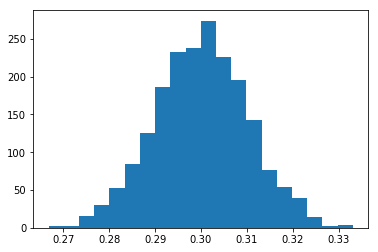

In [21]:
plt.hist(p.e, bins = 20)

(array([ 58., 133., 206., 226., 231., 229., 220., 183., 133., 113.,  87.,
         65.,  47.,  29.,  12.,   9.,  12.,   4.,   1.,   2.]),
 array([ 0.58240805,  3.0160209 ,  5.44963374,  7.88324659, 10.31685944,
        12.75047229, 15.18408513, 17.61769798, 20.05131083, 22.48492368,
        24.91853652, 27.35214937, 29.78576222, 32.21937507, 34.65298792,
        37.08660076, 39.52021361, 41.95382646, 44.38743931, 46.82105215,
        49.254665  ]),
 <a list of 20 Patch objects>)

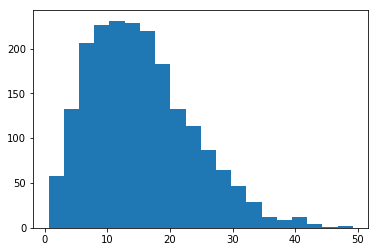

In [22]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([  3.,   3.,  13.,  20.,  37.,  62., 157., 266., 496., 943.]),
 array([6.78946316, 7.11049378, 7.43152441, 7.75255504, 8.07358566,
        8.39461629, 8.71564691, 9.03667754, 9.35770817, 9.67873879,
        9.99976942]),
 <a list of 10 Patch objects>)

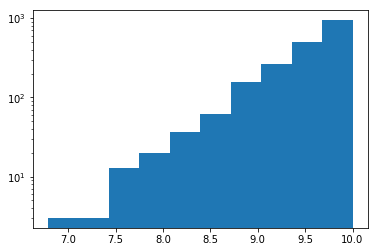

In [23]:
plt.yscale('log', bins = 20)
plt.hist(p.H)

(array([  1.,   3.,  22.,  51., 156., 313., 285., 335., 448., 386.]),
 array([21.73191173, 22.3150711 , 22.89823047, 23.48138984, 24.06454921,
        24.64770858, 25.23086795, 25.81402732, 26.39718669, 26.98034606,
        27.56350543]),
 <a list of 10 Patch objects>)

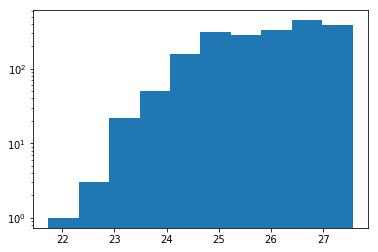

In [24]:
plt.yscale('log', bins = 20)
plt.hist(p.mag)

(array([115., 110., 105.,  92.,  98.,  96.,  95., 105., 106.,  99., 104.,
        108.,  97.,  92.,  92.,  91., 100.,  97., 100.,  98.]),
 array([7.19998735e-04, 6.28965138e-01, 1.25721028e+00, 1.88545542e+00,
        2.51370055e+00, 3.14194569e+00, 3.77019083e+00, 4.39843597e+00,
        5.02668111e+00, 5.65492625e+00, 6.28317139e+00, 6.91141653e+00,
        7.53966166e+00, 8.16790680e+00, 8.79615194e+00, 9.42439708e+00,
        1.00526422e+01, 1.06808874e+01, 1.13091325e+01, 1.19373776e+01,
        1.25656228e+01]),
 <a list of 20 Patch objects>)

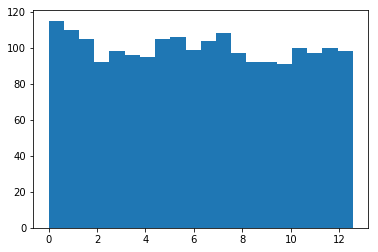

In [25]:
plt.hist(p.M, bins = 20)

(array([116., 100.,  87.,  91., 101.,  94.,  93., 108., 117.,  91.,  85.,
         94.,  92.,  93.,  98., 105., 108., 103., 119., 105.]),
 array([3.16605699e-04, 3.14244692e-01, 6.28172778e-01, 9.42100865e-01,
        1.25602895e+00, 1.56995704e+00, 1.88388512e+00, 2.19781321e+00,
        2.51174130e+00, 2.82566938e+00, 3.13959747e+00, 3.45352556e+00,
        3.76745364e+00, 4.08138173e+00, 4.39530981e+00, 4.70923790e+00,
        5.02316599e+00, 5.33709407e+00, 5.65102216e+00, 5.96495025e+00,
        6.27887833e+00]),
 <a list of 20 Patch objects>)

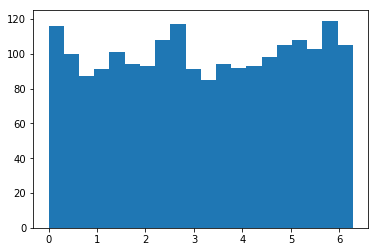

In [26]:
plt.hist(p.arg, bins = 20)

(array([110., 111., 105.,  92.,  91., 106.,  92., 114., 106., 104., 100.,
         90.,  97., 109.,  94.,  93., 100.,  95.,  99.,  92.]),
 array([4.11983027e-03, 3.17915607e-01, 6.31711383e-01, 9.45507160e-01,
        1.25930294e+00, 1.57309871e+00, 1.88689449e+00, 2.20069027e+00,
        2.51448604e+00, 2.82828182e+00, 3.14207760e+00, 3.45587337e+00,
        3.76966915e+00, 4.08346493e+00, 4.39726070e+00, 4.71105648e+00,
        5.02485225e+00, 5.33864803e+00, 5.65244381e+00, 5.96623958e+00,
        6.28003536e+00]),
 <a list of 20 Patch objects>)

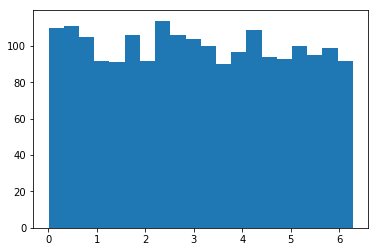

In [27]:
plt.hist(p.node, bins = 20)

(array([ 90., 108., 104., 106., 100.,  98.,  94.,  91.,  98., 112.,  99.,
        102., 101.,  91.,  96., 112., 109.,  79.,  99., 111.]),
 array([2.38373100e-03, 3.16417461e-01, 6.30451190e-01, 9.44484920e-01,
        1.25851865e+00, 1.57255238e+00, 1.88658611e+00, 2.20061984e+00,
        2.51465357e+00, 2.82868730e+00, 3.14272103e+00, 3.45675476e+00,
        3.77078849e+00, 4.08482222e+00, 4.39885595e+00, 4.71288968e+00,
        5.02692341e+00, 5.34095714e+00, 5.65499087e+00, 5.96902460e+00,
        6.28305832e+00]),
 <a list of 20 Patch objects>)

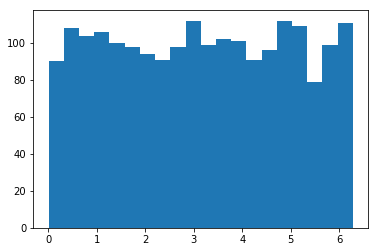

In [28]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([ 13.,  27.,  28.,  66.,  79., 114., 144., 153., 161., 181., 155.,
        188., 143., 154., 133., 127.,  63.,  38.,  21.,  12.]),
 array([3.10783339, 3.11117056, 3.11450773, 3.11784489, 3.12118206,
        3.12451923, 3.12785639, 3.13119356, 3.13453073, 3.13786789,
        3.14120506, 3.14454223, 3.14787939, 3.15121656, 3.15455373,
        3.15789089, 3.16122806, 3.16456523, 3.16790239, 3.17123956,
        3.17457673]),
 <a list of 20 Patch objects>)

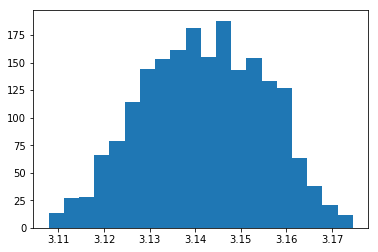

In [29]:
plt.hist(p.phi, bins = 20)

In [30]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [31]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

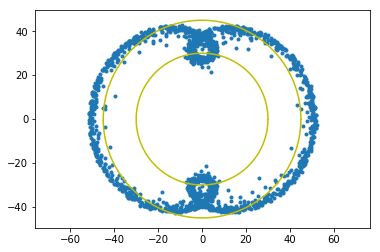

In [32]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')

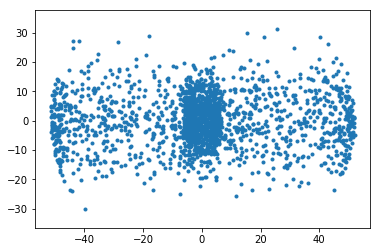

In [33]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

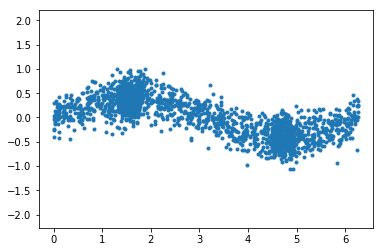

In [34]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')